In [1]:
!pip install tqdm
!pip install torchmetrics

In [9]:
## Import essentials
import numpy as np
import torch
import os
import glob
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm import tqdm
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR



In [3]:
### Create Dataloader

import json
from torch.utils.data import Dataset
from PIL import Image

class BDD_Dataset(Dataset):
    def __init__(self, transforms, split='train'):
        super(BDD_Dataset, self).__init__()
        self.transforms = transforms
        self.split = split

        self.label_dirs = glob.glob(os.path.join("dataset/bdd100k/labels/seg_track_20/rles", split, "*.json"))
        self.data_paths = self.load_data()

        self.label_dict = {
           "pedestrian" :    1,
            "rider":         2,
            "car":           3,
            "truck":         4,
            "bus":           5, 
            "train":         6,
            "motorcycle":    7,
            "bicycle":       8,
            "traffic light": 9,
            "traffic sign":  10
        }
        
    
    def load_data(self):
        data_paths = []
        for lfile in self.label_dirs:
            file = open(lfile)
            json_file_data = json.load(file)
            for frame in json_file_data['frames']:
                name = os.path.join(frame['videoName'], frame['name'])
                all_objects = []
                for object in frame['labels']:
                    label = object['category']
                    x1 = object['box2d']['x1']
                    y1 = object['box2d']['y1']
                    x2 = object['box2d']['x2']
                    y2 = object['box2d']['y2']
                    bbox = [x1, y1, x2, y2]
                    if x1 < 0 or y1 < 0 or x2 < 0 or y2 < 0 or x2 - x1 <= 0 or y2 - y1 <= 0:
                        continue 
                    all_objects.append((label, list(bbox)))
                if len(all_objects) == 0:
                    continue
                data_paths.append((name, all_objects))
                
            file.close()
        return data_paths


    def __len__(self):
        return len(self.data_paths)

    def load_image(self, name):
        img_path = os.path.join(os.path.join("dataset/bdd100k/images/seg_track_20", self.split, name))
        img = Image.open(img_path).convert("RGB")
        return img
        

    def __getitem__(self, idx):
        name, infos = self.data_paths[idx]
        img = self.load_image(name)
        label = []
        bbox = []
        for info in infos:
            label.append(self.label_dict[info[0]])
            bbox.append(info[1])
        label = torch.tensor(label) 
        bbox = torch.tensor(bbox).float()
        targets = {
            "labels" : label,
            "boxes": bbox
        }
        return self.transforms(img), targets



#### Testing 
# d = BDD_Dataset(transforms=transforms.ToTensor(), split='val')
# print(len(d))

####


In [4]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def evaluate(model, data_loader, device, train=False):
    torch.cuda.empty_cache()
    model.eval()
    metric = MeanAveragePrecision()
    with torch.no_grad():
        for idx, (images, targets) in enumerate(data_loader):
            if train and idx > 1000:
                continue
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model.val(images)
            metric.update(outputs, targets)
        result = metric.compute()
        mAP = result['map']
        mAR = result['mar_1']
        f1_score = 2 * (mAP * mAR) / (mAP + mAR)
    
    return mAP, mAR, f1_score
            

In [5]:
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

class Trainer():
    def __init__(self, model, num_epochs, optimizer, train_loader, val_loader, device, save_path, lr_scheduler=None, load_path=None):
        self.model = model
        self.num_epochs = num_epochs
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.lr_scheduler = lr_scheduler
        
        self.save_path = save_path
        if not os.path.exists(save_path):
            os.makedirs(save_path)
            
        self.train_loss_history = defaultdict(list)
        self.val_acc_history = defaultdict(list)
        self.train_acc_history = defaultdict(list)
        
        if load_path is not None:
            checkpoint = torch.load(os.path.join(load_path, 'checkpoint.pt'))
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.train_loss_history = checkpoint['train_loss_history']
            self.train_acc_history = checkpoint['train_acc_history']
            self.val_acc_history = checkpoint['val_acc_history']
    

    def train(self):
        val_acc = -1
        for epoch in range(self.num_epochs):
            torch.cuda.empty_cache()
            self.model.train()
            loss_values = defaultdict(list)
            for images, targets in tqdm(self.train_loader, desc="Iterations: "):
                self.optimizer.zero_grad()
                images = list(image.to(self.device) for image in images)
                targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
                loss_dict = self.model(images, targets)
                final_loss = sum(loss for loss in loss_dict.values())
                final_loss.backward()
                self.optimizer.step()
                for key, value in loss_dict.items():
                    loss_values[key].append(value.item())
            
            if self.lr_scheduler != None:
                self.lr_scheduler.step()
                
            loss_out = ""
            for key, value in loss_values.items():
                mean_ = np.mean(np.array(value))
                self.train_loss_history[key].append(mean_)
                loss_out += key + " = " + str(mean_) + ", "
            tqdm.write("Epoch - "+str(epoch+1)+" : "+loss_out)
            
            if epoch % 3 == 0:
                mAP_train, mAR_train, f1_train = evaluate(self.model, self.train_loader, self.device, train=True)
                mAP_val, mAR_val, f1_val = evaluate(self.model, self.val_loader, self.device)
                tqdm.write("Train Accuracy: mAP="+str(mAP_train.item()))
                tqdm.write("Val Accuracy: mAP="+str(mAP_val.item()))
                self.train_acc_history['mAP'].append(mAP_train.item())
                self.val_acc_history['mAP'].append(mAP_val.item())
                if val_acc < mAP_val:
                    self.save_model()
                    val_acc = mAP_val
    
    def save_model(self):
        torch.save({
        'model_state_dict': self.model.state_dict(),
        'optimizer_state_dict': self.optimizer.state_dict(),
        'train_loss_history': self.train_loss_history,
        'train_acc_history': self.train_acc_history,
        'val_acc_history': self.val_acc_history
    }, os.path.join(self.save_path, 'checkpoint.pt'))
        
    def plot_history(self):
        for key in self.train_loss_history.keys():
            plt.figure(figsize=(4,4))
            iters_ = np.arange(0, len(self.train_loss_history[key]))
            plt.plot(iters_, np.array(self.train_loss_history[key]), label=key)
            plt.legend(loc="upper left")
            plt.show()
        
        for key, value in self.train_acc_history.items():
            plt.figure(figsize=(4,4))
            iters_ = np.arange(0, len(self.train_acc_history[key]))
            plt.plot(iters_, np.array(self.train_acc_history[key]), label="Train "+ key)
            plt.plot(iters_, np.array(self.val_acc_history[key]), label="Val " + key)
            plt.legend(loc="upper left")
            plt.show()
        

    def vis_results(self, threshold):
        torch.cuda.empty_cache()
        self.model.eval()
        label_dict = self.val_loader.dataset.label_dict
        p = dict(zip(label_dict.values(),label_dict.keys()))
        colors = np.random.uniform(0, 255, size=(len(p), 3))
        with torch.no_grad():
            rng = np.random.default_rng()
            idxs = list(rng.choice(len(self.train_loader), size=5, replace=False))
            for idx, (images, targets) in enumerate(self.val_loader):
                if idx in idxs:
                    images = list(image.to(self.device) for image in images)
                    outputs = self.model.val(images)[0]
                    img = images[0].permute(1,2,0).cpu().detach().numpy()
                    img = cv2.cvtColor(np.float32(img), cv2.COLOR_RGB2BGR)
                    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
                    for i in range(len(outputs['boxes'])):
                        if outputs['scores'][i].item() > threshold:
                            label_idx = outputs['labels'][i].item()
                            label = "{}: {:.2f}%".format(p[label_idx], outputs['scores'][i].item() * 100)
                            box = outputs["boxes"][i].detach().cpu().numpy()
                            (startX, startY, endX, endY) = box.astype("int")
                            img = cv2.rectangle(img, (startX, startY), (endX, endY), colors[label_idx], 2)
                            y = startY - 5 if startY - 5 > 5 else startY + 5
                            img = cv2.putText(img, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[label_idx], 2)
                    ax.set_axis_off()
                    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                        
                
                
                
            

In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = BDD_Dataset(transforms=transforms.Compose(
                                        [transforms.ToTensor()])
                                        , split='train')

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8, \
    collate_fn=collate_fn, pin_memory=True)

val_dataset = BDD_Dataset(transforms=transforms.Compose(
                                    [transforms.ToTensor()])
                                    , split='val')

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=4, \
    collate_fn=collate_fn, pin_memory=True)



In [7]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

class model_fasterrcnn_mobilenet(nn.Module):
	def __init__(self, num_classes):
		super(model_fasterrcnn_mobilenet, self).__init__()
  
		backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
		backbone.out_channels = 1280
		anchor_generator = AnchorGenerator(sizes=((64, 128, 512),),
										aspect_ratios=((0.5, 1.0, 2.0),))

		roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
												output_size=5,
												sampling_ratio=2)

		self.model = FasterRCNN(backbone,
						num_classes=num_classes,
						rpn_anchor_generator=anchor_generator,
						box_roi_pool=roi_pooler)


		
	def forward(self, x, targets):
		return self.model(x, targets)

	def val(self, x):
	 	return self.model(x)




In [8]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
from torch.optim.lr_scheduler import StepLR
model = model_fasterrcnn_mobilenet(num_classes=10)
model.to(DEVICE)
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), 1e-3, betas=(0.9, 0.999), weight_decay=1e-4)
optimizer.zero_grad()
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.8)

trainer = Trainer(model, num_epochs, optimizer, train_loader, val_loader, DEVICE, 'checkpoints/mobilenet', lr_scheduler=lr_scheduler)
trainer.train()

Iterations: 100%|██████████| 3799/3799 [24:19<00:00,  2.60it/s]

Epoch - 1 : loss_classifier = 0.1513579781313073, loss_box_reg = 0.17545288970836623, loss_objectness = 0.06846918932216893, loss_rpn_box_reg = 0.048854763101846194, 


Train Accuracy: mAP=0.13769127428531647
Val Accuracy: mAP=0.07612884044647217


Iterations: 100%|██████████| 3799/3799 [24:06<00:00,  2.63it/s]


Epoch - 2 : loss_classifier = 0.125684674416413, loss_box_reg = 0.157166041266129, loss_objectness = 0.04995950167078381, loss_rpn_box_reg = 0.038929180867252194, 


Iterations: 100%|██████████| 3799/3799 [23:56<00:00,  2.64it/s]


Epoch - 3 : loss_classifier = 0.1195077457800841, loss_box_reg = 0.152186192759411, loss_objectness = 0.045782212599196084, loss_rpn_box_reg = 0.036816047420703164, 


Iterations: 100%|██████████| 3799/3799 [24:02<00:00,  2.63it/s]


Epoch - 4 : loss_classifier = 0.11046094160059246, loss_box_reg = 0.14586101650062064, loss_objectness = 0.0405493413305798, loss_rpn_box_reg = 0.03402389655716837, 
Train Accuracy: mAP=0.1984904408454895
Val Accuracy: mAP=0.1092698946595192


Iterations: 100%|██████████| 3799/3799 [22:17<00:00,  2.84it/s]


Epoch - 5 : loss_classifier = 0.1079680492636184, loss_box_reg = 0.1452322907100605, loss_objectness = 0.0387361783394063, loss_rpn_box_reg = 0.033119152086289516, 


Iterations: 100%|██████████| 3799/3799 [21:08<00:00,  2.99it/s]


Epoch - 6 : loss_classifier = 0.10678680075485006, loss_box_reg = 0.14491645791956423, loss_objectness = 0.038158027835437404, loss_rpn_box_reg = 0.03243438487543491, 


Iterations: 100%|██████████| 3799/3799 [21:12<00:00,  2.99it/s]

Epoch - 7 : loss_classifier = 0.1002343266155099, loss_box_reg = 0.13976419887403244, loss_objectness = 0.03448501365760866, loss_rpn_box_reg = 0.030645519281240097, 


Train Accuracy: mAP=0.24046723544597626
Val Accuracy: mAP=0.11918223649263382


Iterations: 100%|██████████| 3799/3799 [21:15<00:00,  2.98it/s]


Epoch - 8 : loss_classifier = 0.09865795631401945, loss_box_reg = 0.13895038459533357, loss_objectness = 0.03400727809769883, loss_rpn_box_reg = 0.030204009404197575, 


Iterations: 100%|██████████| 3799/3799 [21:08<00:00,  2.99it/s]


Epoch - 9 : loss_classifier = 0.09736956383078843, loss_box_reg = 0.13841148027446623, loss_objectness = 0.03334816584717085, loss_rpn_box_reg = 0.02993126173689275, 


Iterations: 100%|██████████| 3799/3799 [21:09<00:00,  2.99it/s]

Epoch - 10 : loss_classifier = 0.09215112966780727, loss_box_reg = 0.13457828429979882, loss_objectness = 0.030656363331757155, loss_rpn_box_reg = 0.028528831181246085, 


Train Accuracy: mAP=0.2480030357837677
Val Accuracy: mAP=0.1234280988574028


Iterations: 100%|██████████| 3799/3799 [21:14<00:00,  2.98it/s]


Epoch - 11 : loss_classifier = 0.09075752158177844, loss_box_reg = 0.13344498273356867, loss_objectness = 0.0300041656270937, loss_rpn_box_reg = 0.028168949101460502, 


Iterations: 100%|██████████| 3799/3799 [21:10<00:00,  2.99it/s]


Epoch - 12 : loss_classifier = 0.08984235790049475, loss_box_reg = 0.13318964920763468, loss_objectness = 0.030003605431294357, loss_rpn_box_reg = 0.028086352562269518, 


Iterations: 100%|██████████| 3799/3799 [21:10<00:00,  2.99it/s]

Epoch - 13 : loss_classifier = 0.08558528378182224, loss_box_reg = 0.12948853171877436, loss_objectness = 0.027789085626501172, loss_rpn_box_reg = 0.026782041692100692, 


Train Accuracy: mAP=0.2871567904949188
Val Accuracy: mAP=0.1225493922829628


Iterations: 100%|██████████| 3799/3799 [21:13<00:00,  2.98it/s]


Epoch - 14 : loss_classifier = 0.0844075187705369, loss_box_reg = 0.12881114093425494, loss_objectness = 0.02733036935614791, loss_rpn_box_reg = 0.026526406701535544, 


Iterations: 100%|██████████| 3799/3799 [21:12<00:00,  2.99it/s]


Epoch - 15 : loss_classifier = 0.08390787520567723, loss_box_reg = 0.12850703256291507, loss_objectness = 0.02716411561265129, loss_rpn_box_reg = 0.026411084323399756, 


Iterations: 100%|██████████| 3799/3799 [21:12<00:00,  2.99it/s]

Epoch - 16 : loss_classifier = 0.0801215692756442, loss_box_reg = 0.12512597393329816, loss_objectness = 0.025184370965284284, loss_rpn_box_reg = 0.025323792182254255, 


Train Accuracy: mAP=0.30174580216407776
Val Accuracy: mAP=0.12318190187215805


Iterations: 100%|██████████| 3799/3799 [21:12<00:00,  2.99it/s]


Epoch - 17 : loss_classifier = 0.07898479475874859, loss_box_reg = 0.12469380739590907, loss_objectness = 0.025047661597730416, loss_rpn_box_reg = 0.02513364724575626, 


Iterations: 100%|██████████| 3799/3799 [21:11<00:00,  2.99it/s]


Epoch - 18 : loss_classifier = 0.07839404906470561, loss_box_reg = 0.12398434791612951, loss_objectness = 0.02468373991988323, loss_rpn_box_reg = 0.024909699300883097, 


Iterations: 100%|██████████| 3799/3799 [21:09<00:00,  2.99it/s]

Epoch - 19 : loss_classifier = 0.07500034444981357, loss_box_reg = 0.12090145343697425, loss_objectness = 0.023144146175008286, loss_rpn_box_reg = 0.024012229413556036, 


Train Accuracy: mAP=0.3246653974056244
Val Accuracy: mAP=0.13086195290088654


Iterations: 100%|██████████| 3799/3799 [21:12<00:00,  2.99it/s]

Epoch - 20 : loss_classifier = 0.07377990196765677, loss_box_reg = 0.1201429900716452, loss_objectness = 0.022816976842331468, loss_rpn_box_reg = 0.023884290153791708, 


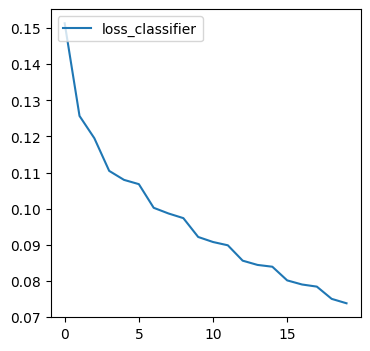

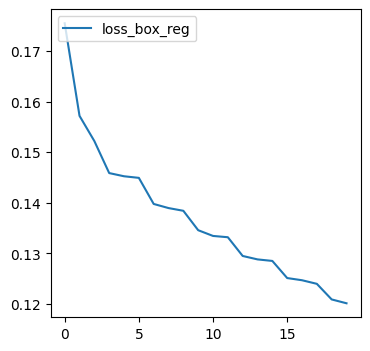

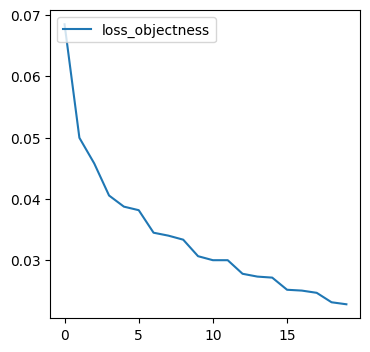

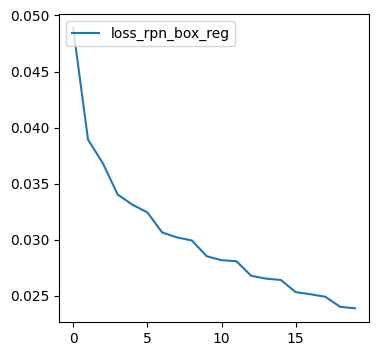

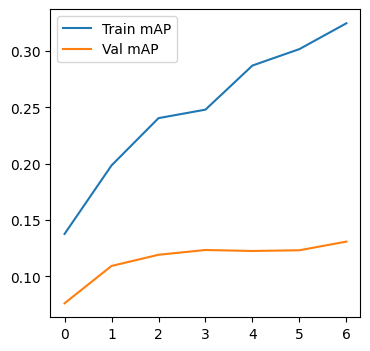

In [9]:
trainer.plot_history()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


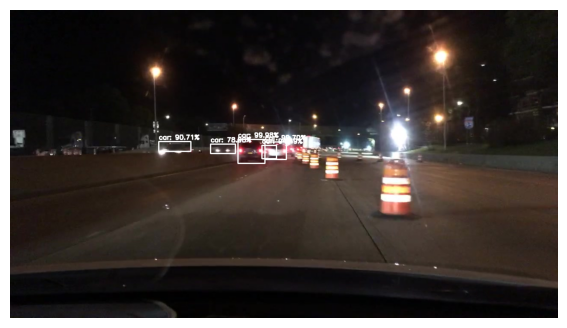

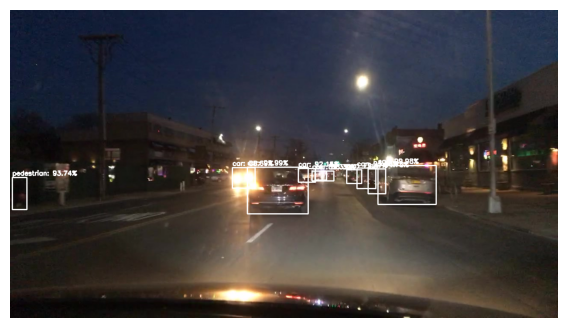

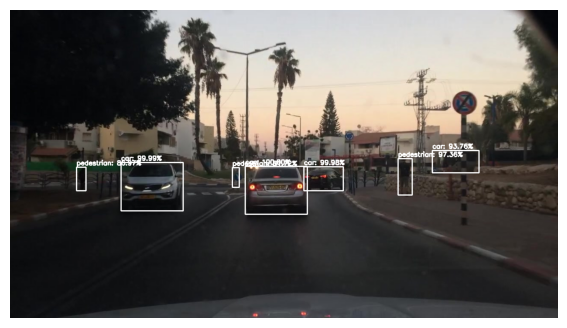

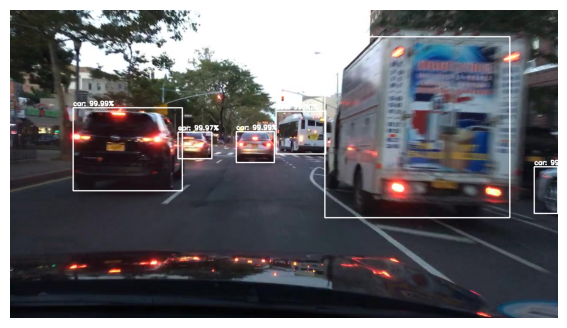

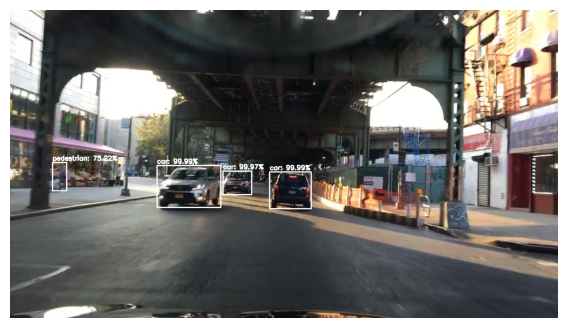

In [10]:
trainer.vis_results(0.75)

In [11]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

class model_fasterrcnn_vgg(nn.Module):
	def __init__(self, num_classes):
		super(model_fasterrcnn_vgg, self).__init__()
  
		backbone = torchvision.models.vgg16(weights="DEFAULT").features
		backbone.out_channels = 512
		anchor_generator = AnchorGenerator(sizes=((64, 128, 512),),
										aspect_ratios=((0.5, 1.0, 2.0),))

		roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
												output_size=5,
												sampling_ratio=2)

		self.model = FasterRCNN(backbone,
						num_classes=num_classes,
						rpn_anchor_generator=anchor_generator,
						box_roi_pool=roi_pooler)


		
	def forward(self, x, targets):
		return self.model(x, targets)

	def val(self, x):
	 	return self.model(x)




In [12]:


DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()
model = model_fasterrcnn_vgg(num_classes=10)
model.to(DEVICE)
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), 1e-3, betas=(0.9, 0.999), weight_decay=1e-4)
optimizer.zero_grad()
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.8)

trainer = Trainer(model, num_epochs, optimizer, train_loader, val_loader, DEVICE, 'checkpoints/vgg16', lr_scheduler)
trainer.train()

Iterations: 100%|██████████| 3799/3799 [45:33<00:00,  1.39it/s]

Epoch - 1 : loss_classifier = 0.19270560436419482, loss_box_reg = 0.1737857200229841, loss_objectness = 0.1343356964167842, loss_rpn_box_reg = 0.06512774346299738, 


Train Accuracy: mAP=0.09555898606777191
Val Accuracy: mAP=0.0574646033346653


Iterations: 100%|██████████| 3799/3799 [45:31<00:00,  1.39it/s]


Epoch - 2 : loss_classifier = 0.14776494268795695, loss_box_reg = 0.16385154203894453, loss_objectness = 0.08540820347100582, loss_rpn_box_reg = 0.04662114280617003, 


Iterations: 100%|██████████| 3799/3799 [45:22<00:00,  1.40it/s]


Epoch - 3 : loss_classifier = 0.13724647501689977, loss_box_reg = 0.15655652019919675, loss_objectness = 0.07804600512753523, loss_rpn_box_reg = 0.04355852705972952, 


Iterations: 100%|██████████| 3799/3799 [45:14<00:00,  1.40it/s]

Epoch - 4 : loss_classifier = 0.12667763279469021, loss_box_reg = 0.15014559242341918, loss_objectness = 0.06977148247315448, loss_rpn_box_reg = 0.04026724497740341, 


Train Accuracy: mAP=0.18516868352890015
Val Accuracy: mAP=0.08714520931243896


Iterations: 100%|██████████| 3799/3799 [45:11<00:00,  1.40it/s]


Epoch - 5 : loss_classifier = 0.122796293167644, loss_box_reg = 0.1475046962876168, loss_objectness = 0.06713755852360181, loss_rpn_box_reg = 0.039286342160209965, 


Iterations: 100%|██████████| 3799/3799 [45:07<00:00,  1.40it/s]


Epoch - 6 : loss_classifier = 0.11974373830579933, loss_box_reg = 0.14585037586245136, loss_objectness = 0.06521884278423945, loss_rpn_box_reg = 0.0385723964490877, 


Iterations: 100%|██████████| 3799/3799 [45:03<00:00,  1.41it/s]

Epoch - 7 : loss_classifier = 0.11416270929430622, loss_box_reg = 0.1420757333025097, loss_objectness = 0.06052738635806417, loss_rpn_box_reg = 0.03669822129667802, 


Train Accuracy: mAP=0.22467724978923798
Val Accuracy: mAP=0.10491719096899033


Iterations: 100%|██████████| 3799/3799 [45:05<00:00,  1.40it/s]


Epoch - 8 : loss_classifier = 0.11221626758277338, loss_box_reg = 0.141326560640561, loss_objectness = 0.059180698844634345, loss_rpn_box_reg = 0.03622940233358233, 


Iterations: 100%|██████████| 3799/3799 [45:01<00:00,  1.41it/s]


Epoch - 9 : loss_classifier = 0.11103531584108337, loss_box_reg = 0.14065062920100815, loss_objectness = 0.05851404166285946, loss_rpn_box_reg = 0.03592905085205357, 


Iterations: 100%|██████████| 3799/3799 [45:00<00:00,  1.41it/s]

Epoch - 10 : loss_classifier = 0.10627519760783895, loss_box_reg = 0.1374803820203781, loss_objectness = 0.05473744259668192, loss_rpn_box_reg = 0.03436182330480906, 


Train Accuracy: mAP=0.2596346139907837
Val Accuracy: mAP=0.1105833500623703


Iterations: 100%|██████████| 3799/3799 [45:04<00:00,  1.40it/s]


Epoch - 11 : loss_classifier = 0.10523921148040069, loss_box_reg = 0.13696080616475031, loss_objectness = 0.05388295804043763, loss_rpn_box_reg = 0.0341182297583994, 


Iterations: 100%|██████████| 3799/3799 [45:04<00:00,  1.40it/s]


Epoch - 12 : loss_classifier = 0.10351554093827038, loss_box_reg = 0.13601360284331349, loss_objectness = 0.053280347760861865, loss_rpn_box_reg = 0.03388503123325803, 


Iterations: 100%|██████████| 3799/3799 [45:02<00:00,  1.41it/s]

Epoch - 13 : loss_classifier = 0.10005824466239123, loss_box_reg = 0.13321682375594168, loss_objectness = 0.050452418293912775, loss_rpn_box_reg = 0.0326322800761506, 


Train Accuracy: mAP=0.2724429666996002
Val Accuracy: mAP=0.11513548344373703


Iterations: 100%|██████████| 3799/3799 [45:07<00:00,  1.40it/s]


Epoch - 14 : loss_classifier = 0.09832833983566956, loss_box_reg = 0.13199509800884654, loss_objectness = 0.049843461969565815, loss_rpn_box_reg = 0.03239894726454121, 


Iterations: 100%|██████████| 3799/3799 [45:09<00:00,  1.40it/s]


Epoch - 15 : loss_classifier = 0.09747933754641058, loss_box_reg = 0.1320722753647347, loss_objectness = 0.049221787512965284, loss_rpn_box_reg = 0.032174154793954926, 


Iterations: 100%|██████████| 3799/3799 [1:19:20<00:00,  1.25s/it]

Epoch - 16 : loss_classifier = 0.09406877442200064, loss_box_reg = 0.12943667329888997, loss_objectness = 0.04692756963286291, loss_rpn_box_reg = 0.031127319901654064, 


Train Accuracy: mAP=0.2865436375141144
Val Accuracy: mAP=0.1248076781630516


Iterations: 100%|██████████| 3799/3799 [1:37:49<00:00,  1.55s/it]


Epoch - 17 : loss_classifier = 0.0927612316642946, loss_box_reg = 0.1289653172694435, loss_objectness = 0.04610055983537246, loss_rpn_box_reg = 0.030907591656056336, 


Iterations: 100%|██████████| 3799/3799 [1:12:57<00:00,  1.15s/it]


Epoch - 18 : loss_classifier = 0.09200127528419963, loss_box_reg = 0.12820825572036135, loss_objectness = 0.045713556925764946, loss_rpn_box_reg = 0.030781503305403957, 


Iterations: 100%|██████████| 3799/3799 [1:26:50<00:00,  1.37s/it]

Epoch - 19 : loss_classifier = 0.08860381461226899, loss_box_reg = 0.12558860545838216, loss_objectness = 0.04366288452489372, loss_rpn_box_reg = 0.02979580404015788, 


Train Accuracy: mAP=0.30306732654571533
Val Accuracy: mAP=0.12464800477027893


Iterations: 100%|██████████| 3799/3799 [1:25:27<00:00,  1.35s/it]

Epoch - 20 : loss_classifier = 0.08797787088988078, loss_box_reg = 0.1252738700880051, loss_objectness = 0.043092997859286795, loss_rpn_box_reg = 0.029640752964592523, 


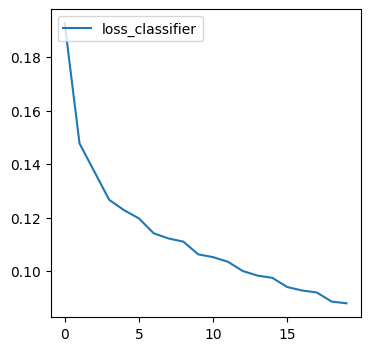

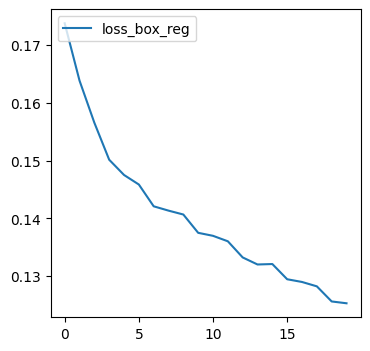

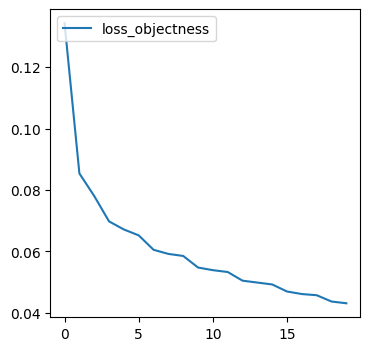

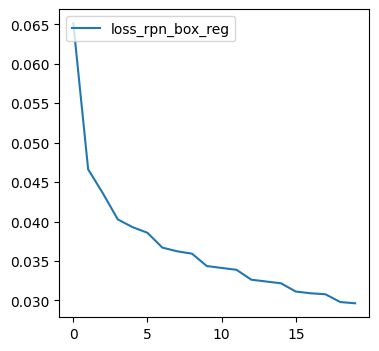

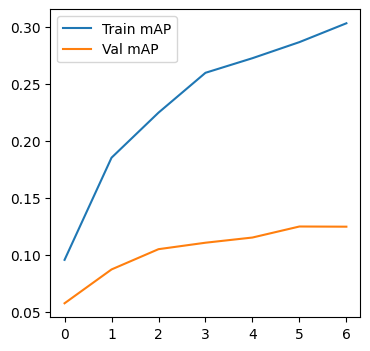

In [13]:
trainer.plot_history()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


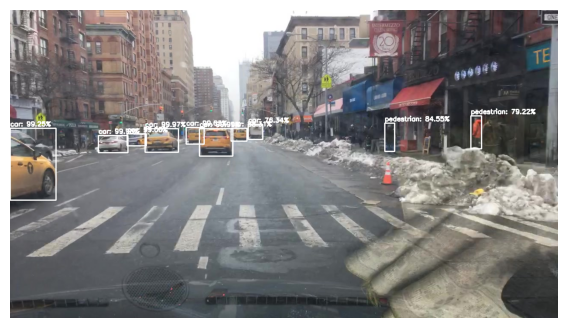

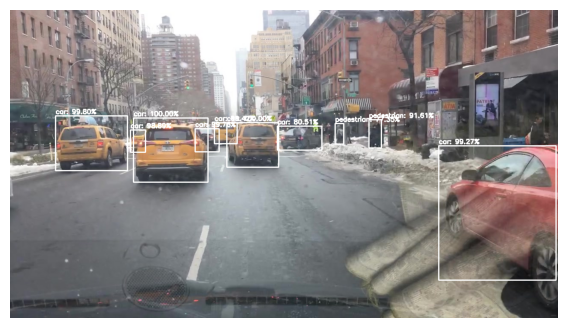

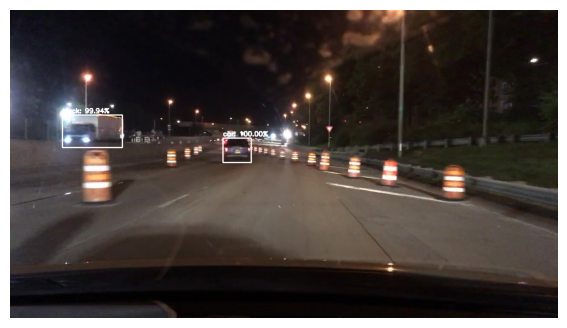

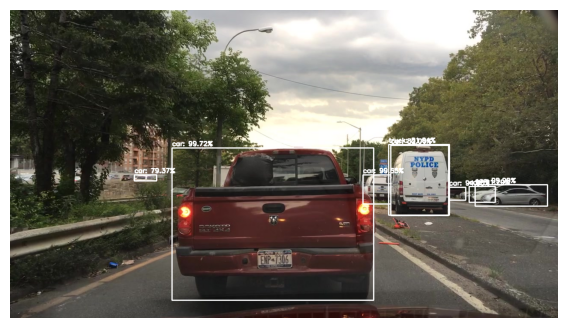

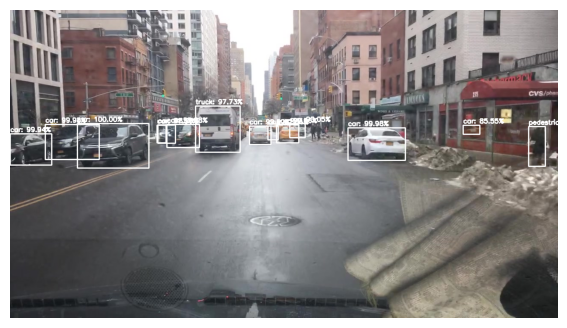

In [14]:
trainer.vis_results(0.75)

In [22]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

class model_fasterrcnn_resnet18(nn.Module):
	def __init__(self, num_classes):
		super(model_fasterrcnn_resnet18, self).__init__()
  
		resnet18 = torchvision.models.resnet18(weights="DEFAULT")
		backbone = torch.nn.Sequential(*(list(resnet18.children())[:-2]))
		backbone.out_channels = 512
		anchor_generator = AnchorGenerator(sizes=((64, 128, 512),),
										aspect_ratios=((0.5, 1.0, 2.0),))

		roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
												output_size=5,
												sampling_ratio=2)

		self.model = FasterRCNN(backbone,
						num_classes=num_classes,
						rpn_anchor_generator=anchor_generator,
						box_roi_pool=roi_pooler)


		
	def forward(self, x, targets):
		return self.model(x, targets)

	def val(self, x):
	 	return self.model(x)




In [23]:

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()
model = model_fasterrcnn_resnet18(num_classes=10)
model.to(DEVICE)
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), 1e-3, betas=(0.9, 0.999), weight_decay=1e-4)
optimizer.zero_grad()
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.8)

trainer = Trainer(model, num_epochs, optimizer, train_loader, val_loader, DEVICE, 'checkpoints/resnet18', lr_scheduler)
trainer.train()

Iterations: 100%|██████████| 3799/3799 [13:51<00:00,  4.57it/s]

Epoch - 1 : loss_classifier = 0.15420904505638017, loss_box_reg = 0.1720966401030183, loss_objectness = 0.07214352527104277, loss_rpn_box_reg = 0.04798407478919427, 


Train Accuracy: mAP=0.156133770942688
Val Accuracy: mAP=0.09101477265357971


Iterations: 100%|██████████| 3799/3799 [11:57<00:00,  5.30it/s]


Epoch - 2 : loss_classifier = 0.12338160650099099, loss_box_reg = 0.152284263407409, loss_objectness = 0.05016215611077604, loss_rpn_box_reg = 0.03755595569458878, 


Iterations: 100%|██████████| 3799/3799 [11:54<00:00,  5.32it/s]


Epoch - 3 : loss_classifier = 0.11576618547383406, loss_box_reg = 0.1457203151552763, loss_objectness = 0.04653639829109361, loss_rpn_box_reg = 0.03562362117692338, 


Iterations: 100%|██████████| 3799/3799 [11:52<00:00,  5.33it/s]

Epoch - 4 : loss_classifier = 0.10728039645456772, loss_box_reg = 0.1397765415129096, loss_objectness = 0.0412459478697147, loss_rpn_box_reg = 0.03313292194820723, 


Train Accuracy: mAP=0.20043815672397614
Val Accuracy: mAP=0.11092421412467957


Iterations: 100%|██████████| 3799/3799 [13:18<00:00,  4.76it/s]


Epoch - 5 : loss_classifier = 0.10518991405590015, loss_box_reg = 0.13856360592903136, loss_objectness = 0.03987666252715144, loss_rpn_box_reg = 0.032395754951839544, 


Iterations: 100%|██████████| 3799/3799 [13:22<00:00,  4.73it/s]


Epoch - 6 : loss_classifier = 0.1028410115836482, loss_box_reg = 0.13688752320713984, loss_objectness = 0.03887079811646895, loss_rpn_box_reg = 0.031958623066550416, 


Iterations: 100%|██████████| 3799/3799 [13:22<00:00,  4.73it/s]

Epoch - 7 : loss_classifier = 0.09722693714578706, loss_box_reg = 0.1332419384923004, loss_objectness = 0.035591430056013534, loss_rpn_box_reg = 0.03015088956316707, 


Train Accuracy: mAP=0.23785164952278137
Val Accuracy: mAP=0.10680893063545227


Iterations: 100%|██████████| 3799/3799 [13:19<00:00,  4.75it/s]


Epoch - 8 : loss_classifier = 0.09541790139113454, loss_box_reg = 0.13166800532298797, loss_objectness = 0.03493930373358496, loss_rpn_box_reg = 0.029944015358934813, 


Iterations: 100%|██████████| 3799/3799 [13:02<00:00,  4.85it/s]


Epoch - 9 : loss_classifier = 0.09493453929626838, loss_box_reg = 0.13172177106208724, loss_objectness = 0.03465249383943187, loss_rpn_box_reg = 0.029602226246566082, 


Iterations: 100%|██████████| 3799/3799 [13:19<00:00,  4.75it/s]

Epoch - 10 : loss_classifier = 0.08938820801908702, loss_box_reg = 0.12764016512774518, loss_objectness = 0.031497279745429776, loss_rpn_box_reg = 0.02821606797246823, 


Train Accuracy: mAP=0.26349374651908875
Val Accuracy: mAP=0.11741585284471512


Iterations: 100%|██████████| 3799/3799 [13:18<00:00,  4.76it/s]


Epoch - 11 : loss_classifier = 0.08811846632185846, loss_box_reg = 0.12744388921923247, loss_objectness = 0.03106338764381749, loss_rpn_box_reg = 0.02789121607569063, 


Iterations: 100%|██████████| 3799/3799 [13:18<00:00,  4.76it/s]


Epoch - 12 : loss_classifier = 0.0875807272470854, loss_box_reg = 0.12679071776876796, loss_objectness = 0.03085353606603363, loss_rpn_box_reg = 0.027809927344079995, 


Iterations: 100%|██████████| 3799/3799 [13:31<00:00,  4.68it/s]

Epoch - 13 : loss_classifier = 0.08248349924251402, loss_box_reg = 0.12347585537671164, loss_objectness = 0.028239281426170885, loss_rpn_box_reg = 0.02646314396840898, 


Train Accuracy: mAP=0.30507251620292664
Val Accuracy: mAP=0.12117896974086761


Iterations: 100%|██████████| 3799/3799 [13:28<00:00,  4.70it/s]


Epoch - 14 : loss_classifier = 0.08176762090761054, loss_box_reg = 0.12284148830423294, loss_objectness = 0.02757635523662438, loss_rpn_box_reg = 0.02619384522859922, 


Iterations: 100%|██████████| 3799/3799 [13:21<00:00,  4.74it/s]


Epoch - 15 : loss_classifier = 0.08125387904780669, loss_box_reg = 0.12298987582855458, loss_objectness = 0.027562701419730325, loss_rpn_box_reg = 0.026141844763881157, 


Iterations: 100%|██████████| 3799/3799 [13:20<00:00,  4.74it/s]

Epoch - 16 : loss_classifier = 0.07638999042680983, loss_box_reg = 0.11890878925498582, loss_objectness = 0.025313315077366862, loss_rpn_box_reg = 0.024882585042536015, 


Train Accuracy: mAP=0.3160040080547333
Val Accuracy: mAP=0.12326912581920624


Iterations: 100%|██████████| 3799/3799 [12:47<00:00,  4.95it/s]


Epoch - 17 : loss_classifier = 0.07524209587963969, loss_box_reg = 0.11826103227617521, loss_objectness = 0.02485539596924957, loss_rpn_box_reg = 0.024664651086344573, 


Iterations: 100%|██████████| 3799/3799 [12:46<00:00,  4.95it/s]


Epoch - 18 : loss_classifier = 0.07488163226931527, loss_box_reg = 0.1176560691592881, loss_objectness = 0.02468838594597942, loss_rpn_box_reg = 0.024514426972577802, 


Iterations: 100%|██████████| 3799/3799 [12:47<00:00,  4.95it/s]

Epoch - 19 : loss_classifier = 0.07106306770618855, loss_box_reg = 0.11435875755610451, loss_objectness = 0.022857894027244304, loss_rpn_box_reg = 0.023470042773261843, 


Train Accuracy: mAP=0.34168878197669983
Val Accuracy: mAP=0.12015412002801895


Iterations: 100%|██████████| 3799/3799 [12:48<00:00,  4.94it/s]

Epoch - 20 : loss_classifier = 0.07001029693421783, loss_box_reg = 0.11380761248731525, loss_objectness = 0.022432541617254352, loss_rpn_box_reg = 0.023303015157212652, 


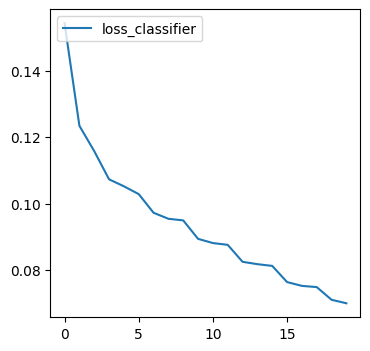

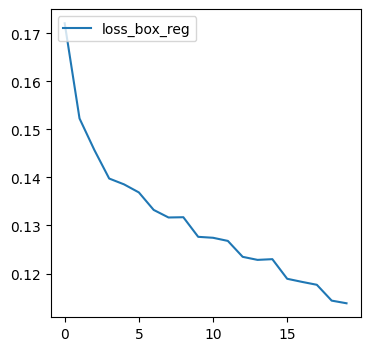

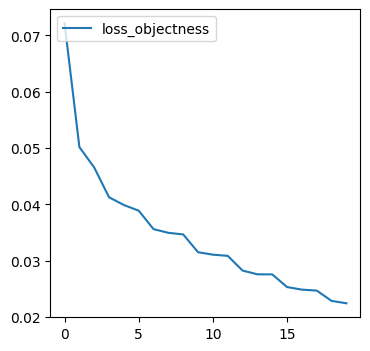

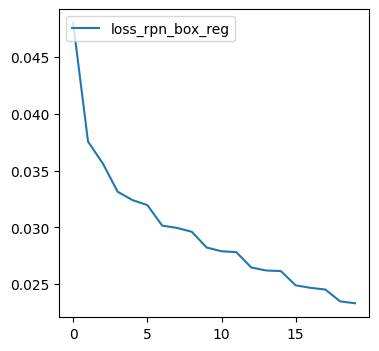

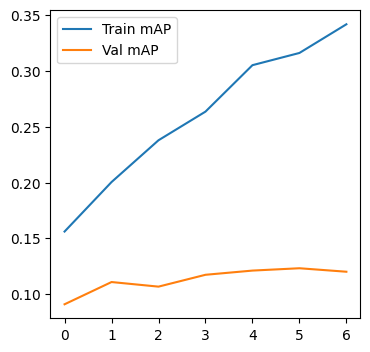

In [24]:
trainer.plot_history()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


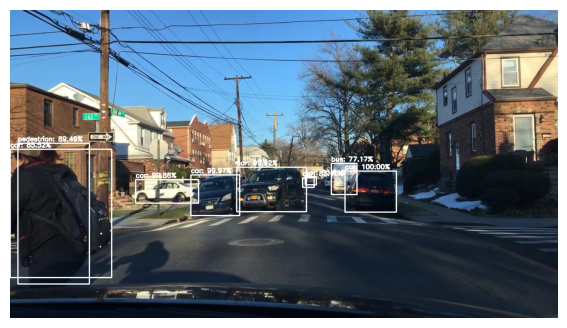

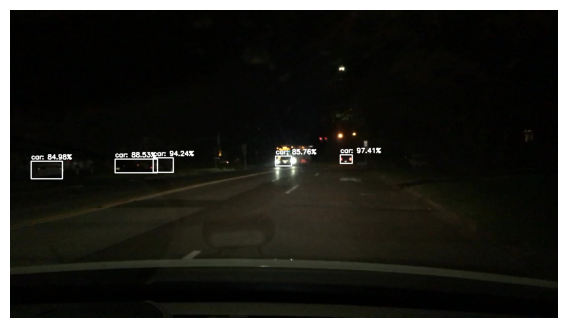

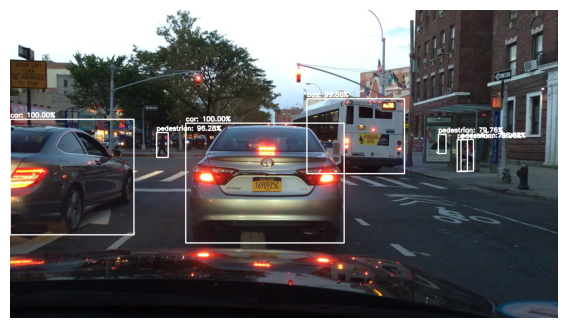

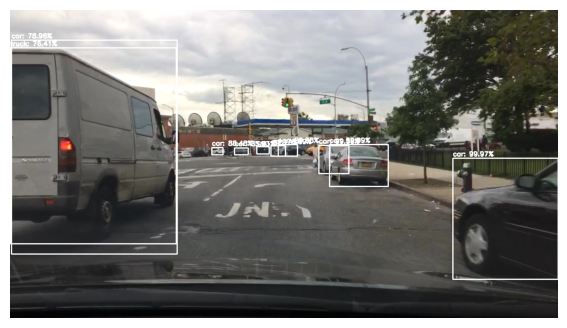

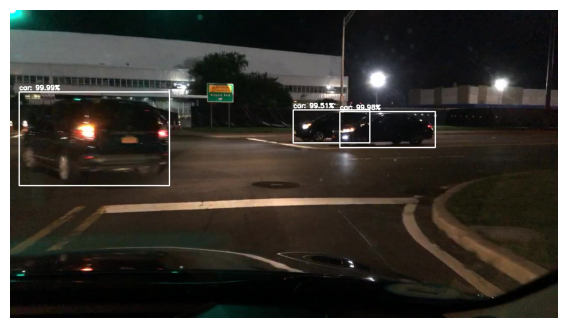

In [25]:
trainer.vis_results(0.75)

In [26]:

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()
model = model_fasterrcnn_resnet18(num_classes=10)
model.to(DEVICE)
num_epochs = 20
optimizer = torch.optim.SGD(model.parameters(), 1e-3, momentum=0.9, weight_decay=1e-4)
optimizer.zero_grad()
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.8)

trainer = Trainer(model, num_epochs, optimizer, train_loader, val_loader, DEVICE, 'checkpoints/resnet18-sgd', lr_scheduler)
trainer.train()

Iterations: 100%|██████████| 3799/3799 [12:56<00:00,  4.89it/s]

Epoch - 1 : loss_classifier = 0.20135340787848852, loss_box_reg = 0.20088679563066825, loss_objectness = 0.11941516848203068, loss_rpn_box_reg = 0.061510792500715755, 


Train Accuracy: mAP=0.06716635823249817
Val Accuracy: mAP=0.051790595054626465


Iterations: 100%|██████████| 3799/3799 [12:56<00:00,  4.89it/s]


Epoch - 2 : loss_classifier = 0.15487985182715328, loss_box_reg = 0.1855822154454383, loss_objectness = 0.06841933589392381, loss_rpn_box_reg = 0.04609680496314092, 


Iterations: 100%|██████████| 3799/3799 [12:57<00:00,  4.89it/s]


Epoch - 3 : loss_classifier = 0.13539572096782534, loss_box_reg = 0.1693902915423561, loss_objectness = 0.056536185310255796, loss_rpn_box_reg = 0.0410313652948459, 


Iterations: 100%|██████████| 3799/3799 [12:58<00:00,  4.88it/s]

Epoch - 4 : loss_classifier = 0.12426435630881306, loss_box_reg = 0.16084493107350445, loss_objectness = 0.04981301448039002, loss_rpn_box_reg = 0.0379299575075111, 


Train Accuracy: mAP=0.1626962423324585
Val Accuracy: mAP=0.09519747644662857


Iterations: 100%|██████████| 3799/3799 [12:58<00:00,  4.88it/s]


Epoch - 5 : loss_classifier = 0.11668976964970801, loss_box_reg = 0.15582283892210108, loss_objectness = 0.04566447613488713, loss_rpn_box_reg = 0.03606961825364874, 


Iterations: 100%|██████████| 3799/3799 [12:59<00:00,  4.88it/s]


Epoch - 6 : loss_classifier = 0.11118214747668191, loss_box_reg = 0.15174455331576187, loss_objectness = 0.04255497468418237, loss_rpn_box_reg = 0.03461626490416747, 


Iterations: 100%|██████████| 3799/3799 [12:58<00:00,  4.88it/s]

Epoch - 7 : loss_classifier = 0.1058341110202161, loss_box_reg = 0.1474257000800684, loss_objectness = 0.03991358819294836, loss_rpn_box_reg = 0.03323286957891717, 


Train Accuracy: mAP=0.20847325026988983
Val Accuracy: mAP=0.10930304229259491


Iterations: 100%|██████████| 3799/3799 [12:58<00:00,  4.88it/s]


Epoch - 8 : loss_classifier = 0.10229457356476979, loss_box_reg = 0.1449049006726874, loss_objectness = 0.038108150863534106, loss_rpn_box_reg = 0.03240626710794315, 


Iterations: 100%|██████████| 3799/3799 [12:58<00:00,  4.88it/s]


Epoch - 9 : loss_classifier = 0.09895601037474926, loss_box_reg = 0.1423624222791722, loss_objectness = 0.03658236492896871, loss_rpn_box_reg = 0.031726946630158466, 


Iterations: 100%|██████████| 3799/3799 [12:58<00:00,  4.88it/s]

Epoch - 10 : loss_classifier = 0.09604311175301189, loss_box_reg = 0.13973825313807883, loss_objectness = 0.03534066963648641, loss_rpn_box_reg = 0.030832869407680905, 


Train Accuracy: mAP=0.23271577060222626
Val Accuracy: mAP=0.11617058515548706


Iterations: 100%|██████████| 3799/3799 [12:58<00:00,  4.88it/s]


Epoch - 11 : loss_classifier = 0.09354853911497431, loss_box_reg = 0.13803802538495466, loss_objectness = 0.03422446503120328, loss_rpn_box_reg = 0.030361449438367636, 


Iterations: 100%|██████████| 3799/3799 [12:59<00:00,  4.88it/s]


Epoch - 12 : loss_classifier = 0.09153775585838354, loss_box_reg = 0.13649538898937136, loss_objectness = 0.033257640683476815, loss_rpn_box_reg = 0.02991151800474765, 


Iterations: 100%|██████████| 3799/3799 [12:58<00:00,  4.88it/s]

Epoch - 13 : loss_classifier = 0.08914790157582704, loss_box_reg = 0.13419462586761652, loss_objectness = 0.03233810319134019, loss_rpn_box_reg = 0.029374834231710664, 


Train Accuracy: mAP=0.25968119502067566
Val Accuracy: mAP=0.12053757905960083


Iterations: 100%|██████████| 3799/3799 [12:57<00:00,  4.88it/s]


Epoch - 14 : loss_classifier = 0.08781953968370501, loss_box_reg = 0.1334495366229591, loss_objectness = 0.03166335550972579, loss_rpn_box_reg = 0.02903021870854635, 


Iterations: 100%|██████████| 3799/3799 [12:58<00:00,  4.88it/s]


Epoch - 15 : loss_classifier = 0.0861903877674388, loss_box_reg = 0.13227435818104313, loss_objectness = 0.030960928085602076, loss_rpn_box_reg = 0.02870445054859927, 


Iterations: 100%|██████████| 3799/3799 [12:58<00:00,  4.88it/s]

Epoch - 16 : loss_classifier = 0.08457779866785682, loss_box_reg = 0.1309018843954615, loss_objectness = 0.03038911060137156, loss_rpn_box_reg = 0.028315452815904512, 


Train Accuracy: mAP=0.2739863991737366
Val Accuracy: mAP=0.12394540756940842


Iterations: 100%|██████████| 3799/3799 [12:57<00:00,  4.88it/s]


Epoch - 17 : loss_classifier = 0.08341250048029043, loss_box_reg = 0.12978884058818907, loss_objectness = 0.029856552402987766, loss_rpn_box_reg = 0.02808867118726591, 


Iterations: 100%|██████████| 3799/3799 [12:59<00:00,  4.87it/s]


Epoch - 18 : loss_classifier = 0.08248696157575892, loss_box_reg = 0.12910993408806923, loss_objectness = 0.0293844437597319, loss_rpn_box_reg = 0.027872497936974005, 


Iterations: 100%|██████████| 3799/3799 [12:59<00:00,  4.88it/s]

Epoch - 19 : loss_classifier = 0.0813403666876482, loss_box_reg = 0.1280956277665448, loss_objectness = 0.028957113266191253, loss_rpn_box_reg = 0.027563991944523046, 


Train Accuracy: mAP=0.2850475311279297
Val Accuracy: mAP=0.12463246285915375


Iterations: 100%|██████████| 3799/3799 [12:58<00:00,  4.88it/s]

Epoch - 20 : loss_classifier = 0.0803202163682043, loss_box_reg = 0.1271930312888344, loss_objectness = 0.02860024502286631, loss_rpn_box_reg = 0.027364421561585896, 


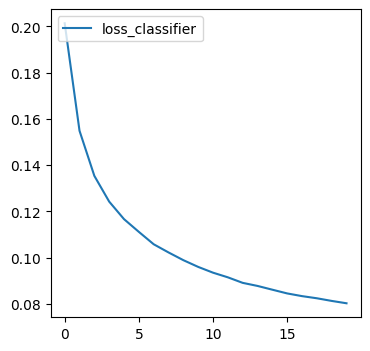

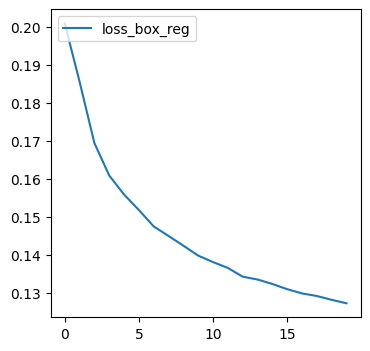

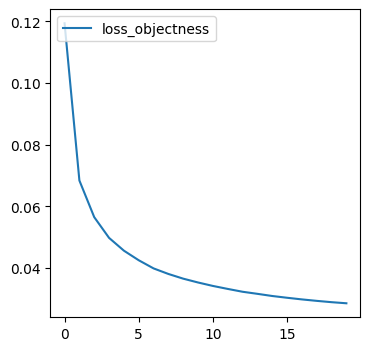

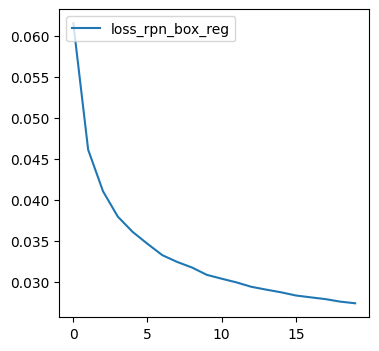

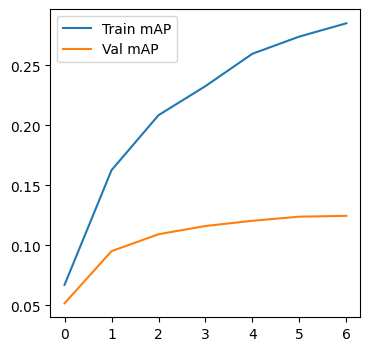

In [27]:
trainer.plot_history()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


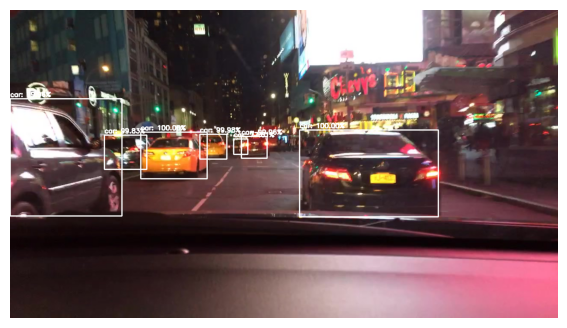

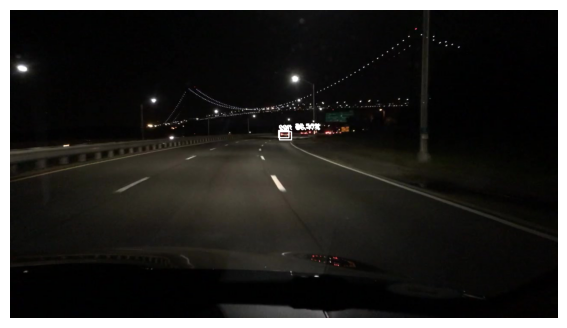

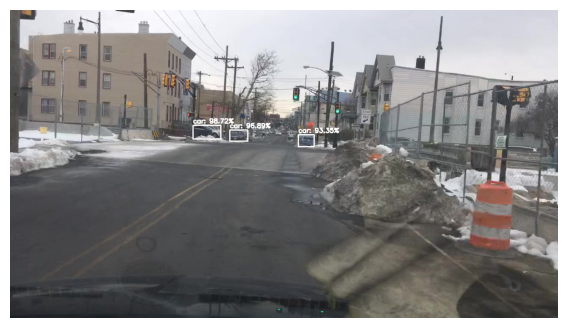

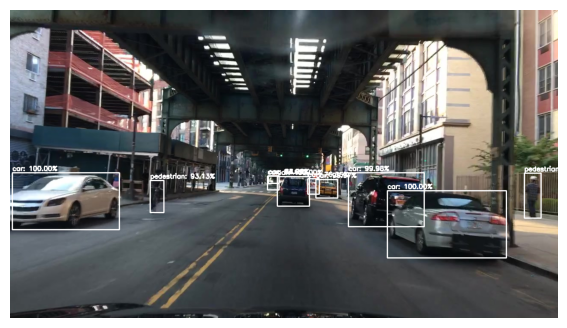

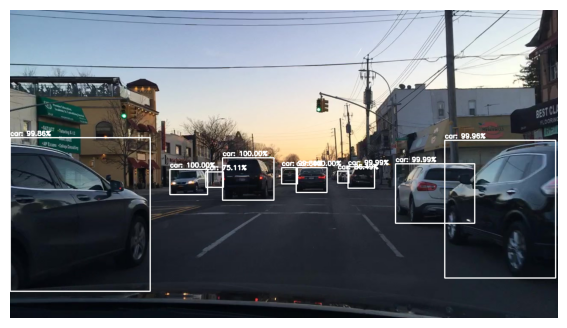

In [28]:
trainer.vis_results(0.75)

In [10]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

class model_fasterrcnn_resnet34(nn.Module):
	def __init__(self, num_classes):
		super(model_fasterrcnn_resnet34, self).__init__()
  
		resnet18 = torchvision.models.resnet34(weights="DEFAULT")
		backbone = torch.nn.Sequential(*(list(resnet18.children())[:-2]))
		backbone.out_channels = 512
		anchor_generator = AnchorGenerator(sizes=((64, 128, 512),),
										aspect_ratios=((0.5, 1.0, 2.0),))

		roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
												output_size=5,
												sampling_ratio=2)

		self.model = FasterRCNN(backbone,
						num_classes=num_classes,
						rpn_anchor_generator=anchor_generator,
						box_roi_pool=roi_pooler)


		
	def forward(self, x, targets):
		return self.model(x, targets)

	def val(self, x):
	 	return self.model(x)




In [11]:

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()
model = model_fasterrcnn_resnet34(num_classes=10)
model.to(DEVICE)
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), 1e-3, betas=(0.9, 0.999), weight_decay=1e-4)
optimizer.zero_grad()
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.8)

trainer = Trainer(model, num_epochs, optimizer, train_loader, val_loader, DEVICE, 'checkpoints/resnet34', lr_scheduler)
trainer.train()

Iterations:  76%|███████▌  | 2876/3799 [15:14<04:48,  3.20it/s]

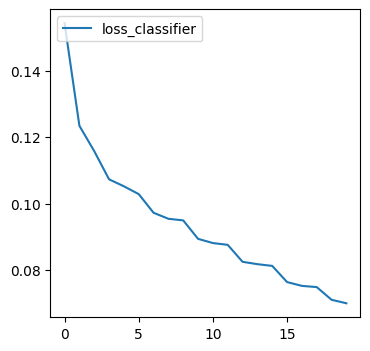

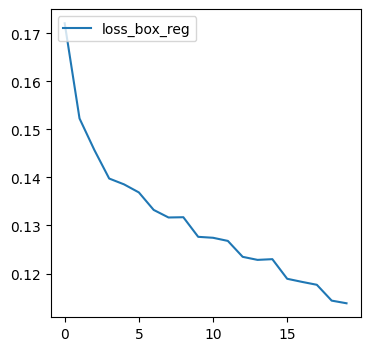

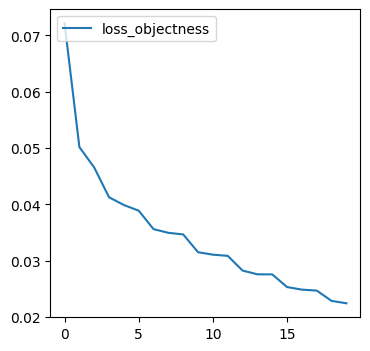

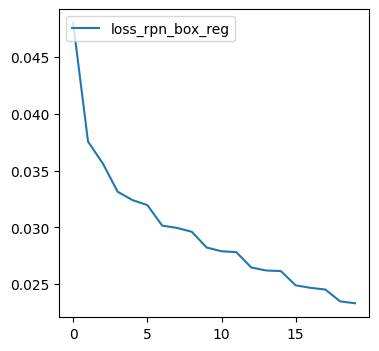

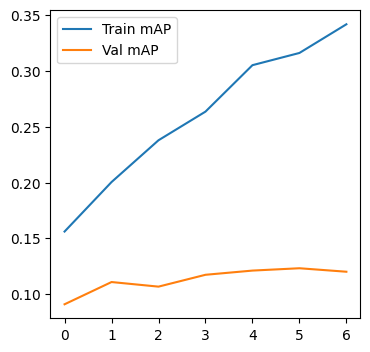

In [ ]:
trainer.plot_history()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


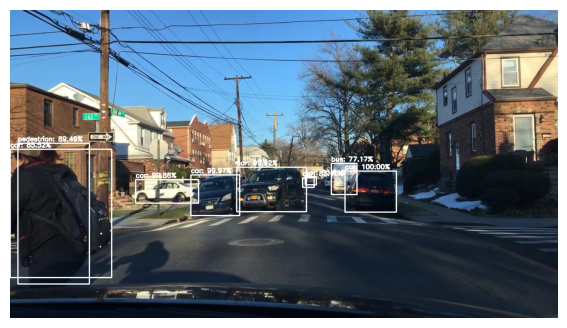

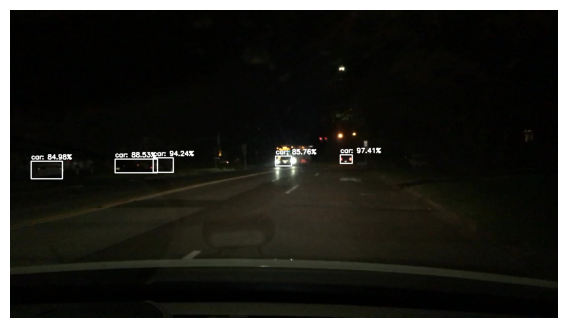

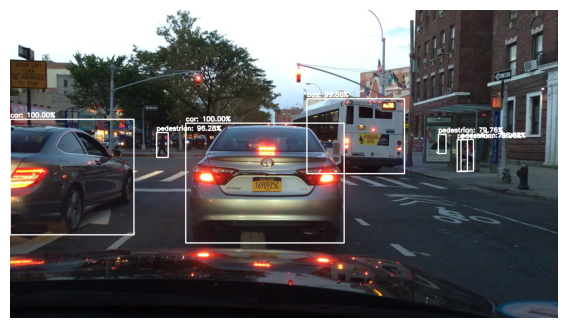

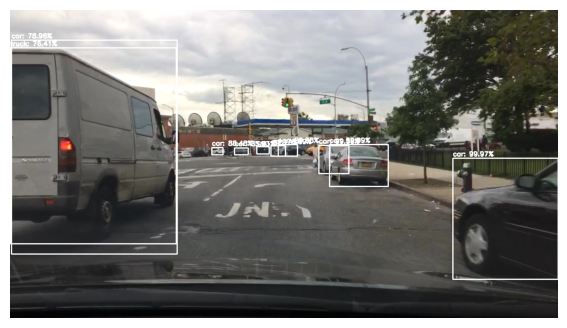

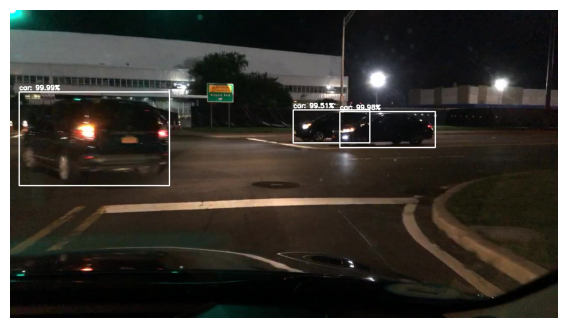

In [ ]:
trainer.vis_results(0.75)

In [ ]:

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()
model = model_fasterrcnn_resnet34(num_classes=10)
model.to(DEVICE)
num_epochs = 20
optimizer = torch.optim.SGD(model.parameters(), 1e-3, momentum=0.9, weight_decay=1e-4)
optimizer.zero_grad()
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.8)

trainer = Trainer(model, num_epochs, optimizer, train_loader, val_loader, DEVICE, 'checkpoints/resnet34-sgd', lr_scheduler)
trainer.train()

Iterations: 100%|██████████| 3799/3799 [12:56<00:00,  4.89it/s]

Epoch - 1 : loss_classifier = 0.20135340787848852, loss_box_reg = 0.20088679563066825, loss_objectness = 0.11941516848203068, loss_rpn_box_reg = 0.061510792500715755, 


Train Accuracy: mAP=0.06716635823249817
Val Accuracy: mAP=0.051790595054626465


Iterations: 100%|██████████| 3799/3799 [12:56<00:00,  4.89it/s]


Epoch - 2 : loss_classifier = 0.15487985182715328, loss_box_reg = 0.1855822154454383, loss_objectness = 0.06841933589392381, loss_rpn_box_reg = 0.04609680496314092, 


Iterations: 100%|██████████| 3799/3799 [12:57<00:00,  4.89it/s]


Epoch - 3 : loss_classifier = 0.13539572096782534, loss_box_reg = 0.1693902915423561, loss_objectness = 0.056536185310255796, loss_rpn_box_reg = 0.0410313652948459, 


Iterations: 100%|██████████| 3799/3799 [12:58<00:00,  4.88it/s]

Epoch - 4 : loss_classifier = 0.12426435630881306, loss_box_reg = 0.16084493107350445, loss_objectness = 0.04981301448039002, loss_rpn_box_reg = 0.0379299575075111, 


Train Accuracy: mAP=0.1626962423324585
Val Accuracy: mAP=0.09519747644662857


Iterations: 100%|██████████| 3799/3799 [12:58<00:00,  4.88it/s]


Epoch - 5 : loss_classifier = 0.11668976964970801, loss_box_reg = 0.15582283892210108, loss_objectness = 0.04566447613488713, loss_rpn_box_reg = 0.03606961825364874, 


Iterations: 100%|██████████| 3799/3799 [12:59<00:00,  4.88it/s]


Epoch - 6 : loss_classifier = 0.11118214747668191, loss_box_reg = 0.15174455331576187, loss_objectness = 0.04255497468418237, loss_rpn_box_reg = 0.03461626490416747, 


Iterations: 100%|██████████| 3799/3799 [12:58<00:00,  4.88it/s]

Epoch - 7 : loss_classifier = 0.1058341110202161, loss_box_reg = 0.1474257000800684, loss_objectness = 0.03991358819294836, loss_rpn_box_reg = 0.03323286957891717, 


Train Accuracy: mAP=0.20847325026988983
Val Accuracy: mAP=0.10930304229259491


Iterations: 100%|██████████| 3799/3799 [12:58<00:00,  4.88it/s]


Epoch - 8 : loss_classifier = 0.10229457356476979, loss_box_reg = 0.1449049006726874, loss_objectness = 0.038108150863534106, loss_rpn_box_reg = 0.03240626710794315, 


Iterations: 100%|██████████| 3799/3799 [12:58<00:00,  4.88it/s]


Epoch - 9 : loss_classifier = 0.09895601037474926, loss_box_reg = 0.1423624222791722, loss_objectness = 0.03658236492896871, loss_rpn_box_reg = 0.031726946630158466, 


Iterations: 100%|██████████| 3799/3799 [12:58<00:00,  4.88it/s]

Epoch - 10 : loss_classifier = 0.09604311175301189, loss_box_reg = 0.13973825313807883, loss_objectness = 0.03534066963648641, loss_rpn_box_reg = 0.030832869407680905, 


Train Accuracy: mAP=0.23271577060222626
Val Accuracy: mAP=0.11617058515548706


Iterations: 100%|██████████| 3799/3799 [12:58<00:00,  4.88it/s]


Epoch - 11 : loss_classifier = 0.09354853911497431, loss_box_reg = 0.13803802538495466, loss_objectness = 0.03422446503120328, loss_rpn_box_reg = 0.030361449438367636, 


Iterations: 100%|██████████| 3799/3799 [12:59<00:00,  4.88it/s]


Epoch - 12 : loss_classifier = 0.09153775585838354, loss_box_reg = 0.13649538898937136, loss_objectness = 0.033257640683476815, loss_rpn_box_reg = 0.02991151800474765, 


Iterations: 100%|██████████| 3799/3799 [12:58<00:00,  4.88it/s]

Epoch - 13 : loss_classifier = 0.08914790157582704, loss_box_reg = 0.13419462586761652, loss_objectness = 0.03233810319134019, loss_rpn_box_reg = 0.029374834231710664, 


Train Accuracy: mAP=0.25968119502067566
Val Accuracy: mAP=0.12053757905960083


Iterations: 100%|██████████| 3799/3799 [12:57<00:00,  4.88it/s]


Epoch - 14 : loss_classifier = 0.08781953968370501, loss_box_reg = 0.1334495366229591, loss_objectness = 0.03166335550972579, loss_rpn_box_reg = 0.02903021870854635, 


Iterations: 100%|██████████| 3799/3799 [12:58<00:00,  4.88it/s]


Epoch - 15 : loss_classifier = 0.0861903877674388, loss_box_reg = 0.13227435818104313, loss_objectness = 0.030960928085602076, loss_rpn_box_reg = 0.02870445054859927, 


Iterations: 100%|██████████| 3799/3799 [12:58<00:00,  4.88it/s]

Epoch - 16 : loss_classifier = 0.08457779866785682, loss_box_reg = 0.1309018843954615, loss_objectness = 0.03038911060137156, loss_rpn_box_reg = 0.028315452815904512, 


Train Accuracy: mAP=0.2739863991737366
Val Accuracy: mAP=0.12394540756940842


Iterations: 100%|██████████| 3799/3799 [12:57<00:00,  4.88it/s]


Epoch - 17 : loss_classifier = 0.08341250048029043, loss_box_reg = 0.12978884058818907, loss_objectness = 0.029856552402987766, loss_rpn_box_reg = 0.02808867118726591, 


Iterations: 100%|██████████| 3799/3799 [12:59<00:00,  4.87it/s]


Epoch - 18 : loss_classifier = 0.08248696157575892, loss_box_reg = 0.12910993408806923, loss_objectness = 0.0293844437597319, loss_rpn_box_reg = 0.027872497936974005, 


Iterations: 100%|██████████| 3799/3799 [12:59<00:00,  4.88it/s]

Epoch - 19 : loss_classifier = 0.0813403666876482, loss_box_reg = 0.1280956277665448, loss_objectness = 0.028957113266191253, loss_rpn_box_reg = 0.027563991944523046, 


Train Accuracy: mAP=0.2850475311279297
Val Accuracy: mAP=0.12463246285915375


Iterations: 100%|██████████| 3799/3799 [12:58<00:00,  4.88it/s]

Epoch - 20 : loss_classifier = 0.0803202163682043, loss_box_reg = 0.1271930312888344, loss_objectness = 0.02860024502286631, loss_rpn_box_reg = 0.027364421561585896, 


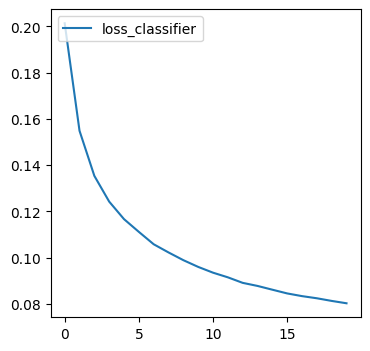

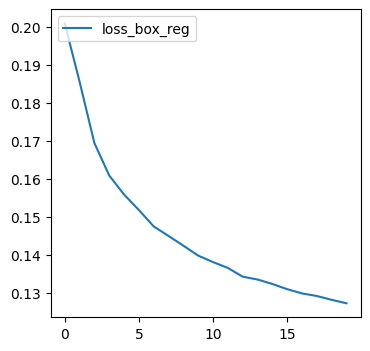

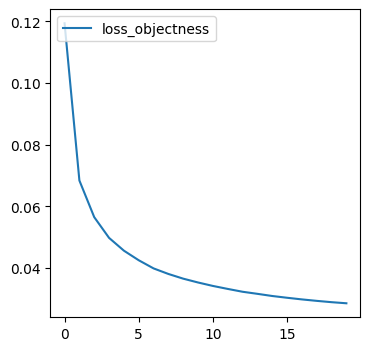

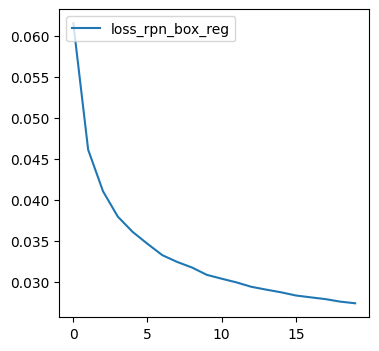

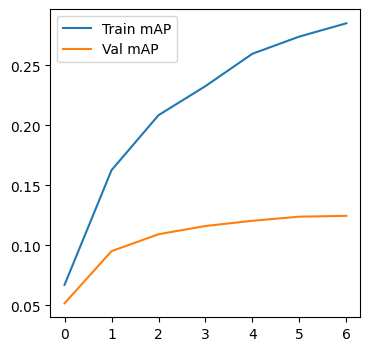

In [ ]:
trainer.plot_history()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


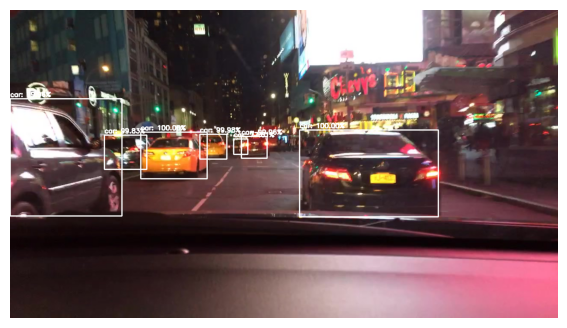

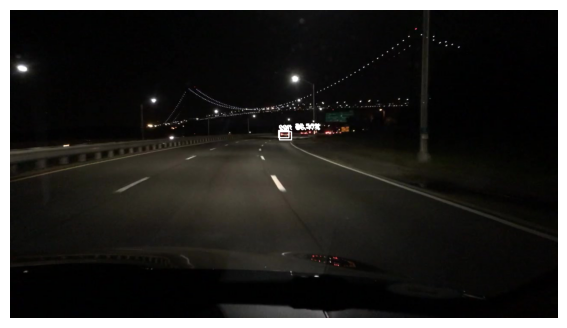

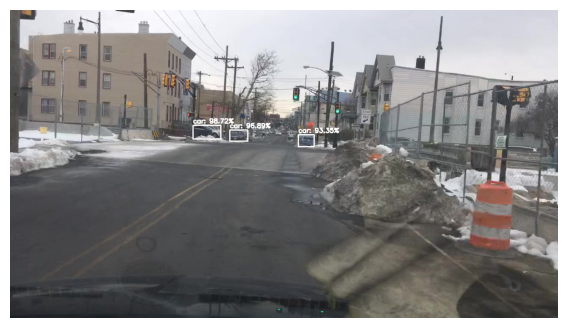

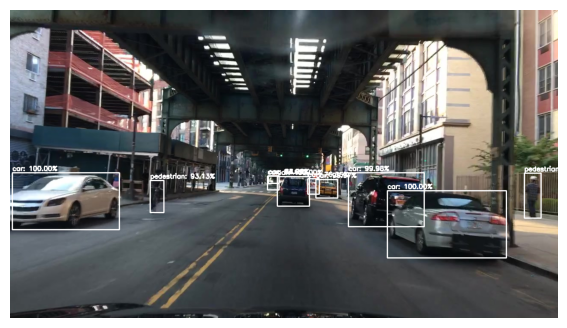

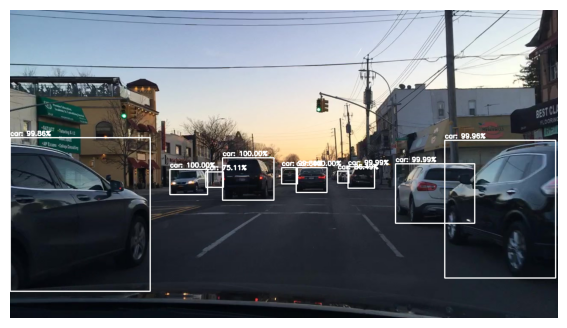

In [ ]:
trainer.vis_results(0.75)

In [ ]:
from torchvision.models.detection import RetinaNet
from torchvision.models.detection.rpn import AnchorGenerator

class model_retinanet_resnet34(nn.Module):
	def __init__(self, num_classes):
		super(model_retinanet_resnet34, self).__init__()
  
		resnet18 = torchvision.models.resnet34(weights="DEFAULT")
		backbone = torch.nn.Sequential(*(list(resnet18.children())[:-2]))
		backbone.out_channels = 512
		anchor_generator = AnchorGenerator(sizes=((64, 128, 512),),
										aspect_ratios=((0.5, 1.0, 2.0),))

		self.model = RetinaNet(backbone,
						num_classes=num_classes,
						anchor_generator=anchor_generator)


		
	def forward(self, x, targets):
		return self.model(x, targets)

	def val(self, x):
	 	return self.model(x)




In [ ]:

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()
model = model_retinanet_resnet34(num_classes=10)
model.to(DEVICE)
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), 1e-3, betas=(0.9, 0.999), weight_decay=1e-4)
optimizer.zero_grad()
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.8)

trainer = Trainer(model, num_epochs, optimizer, train_loader, val_loader, DEVICE, 'checkpoints/retina-resnet34', lr_scheduler)
trainer.train()

Iterations:   0%|          | 0/3799 [00:00<?, ?it/s]


AssertionError: Anchors should be Tuple[Tuple[int]] because each feature map could potentially have different sizes and aspect ratios. There needs to be a match between the number of feature maps passed and the number of sizes / aspect ratios specified.

In [ ]:
trainer.plot_history()

In [ ]:
trainer.vis_results(0.75)